In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

In [2]:
def scatter_plot(x, y, xlabel, ylabel, title):
    g = sns.JointGrid()
    sns.scatterplot(x=x, y=y, ax=g.ax_joint) # can set s=10
    sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x) 
    sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)

    g.ax_joint.set(xlabel=xlabel, ylabel=ylabel)

    g.ax_joint.plot([np.min(x), np.max(x)], [np.min(x), np.max(x)], linewidth=1.0, color='black', linestyle='solid', label='Equality Line')

    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b

    g.ax_joint.plot(x2, y2, 'r--', linewidth=3.0, label='Linear Regression Line')
    g.ax_joint.legend()
    
    pearson_correlation = pearsonr(x,y)[0]

    g.ax_joint.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    print("Reg Slope:", w)

    g.fig.suptitle(title, y=1.05)

    plt.show()

def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    x = x.to_numpy()
    y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
#     plt.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
    
def get_corr_plot(array, title, labels, partial_correlation=False, fig_size=None, fix_colorbar_scale=False,
                 xlabel=None, ylabel=None):
    with sns.axes_style("white"):
        if fig_size == None:
            fig = plt.figure() # can set figsize=(fig_size = 12.8, fig_size)
        else:
            fig = plt.figure(figsize=(fig_size, fig_size))
        ax = fig.add_subplot(111)
        if fix_colorbar_scale == True:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis', vmin=0, vmax=1)
        else:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis')
        fig.colorbar(cax)
        if partial_correlation == False:
            intro = "Pearson R"
        else:
            intro = "Partial Correlation"
        plt.title("{} for {}".format(intro, title), fontsize=fig_size+5 if fig_size != None else 10)
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels)
        ax.xaxis.set_ticks_position("bottom")
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        plt.show()

def correlation_plot(df, key, title, partial_correlation= False, fig_size=None, fix_colorbar_scale=False):
    
    names = df.modality.to_list()
    
    if partial_correlation == False:
        corr_df1 = []
        for idx1 in range(len(df)):
            df1 = df.iloc[idx1].dataframe
            corr_df2 = []
            for idx2 in range(len(df)):
                df2 = df.iloc[idx2].dataframe
                r, _ = pearsonr(df1[key], df2[key])
                corr_df2.append(r)
            corr_df2 = np.array(corr_df2).astype('float32')
            corr_df1.append(corr_df2)
        corr_df1 = np.array(corr_df1).astype('float32')
        get_corr_plot(corr_df1, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
    else:
        tmp_dct = {}
        for idx in range(len(df)):
            tmp_df = df.iloc[idx].dataframe[key]
            tmp_dct[names[idx]] = tmp_df.to_numpy()
        pcorr_df = pd.DataFrame.from_dict(tmp_dct)
        del tmp_dct, tmp_df
        
        # This implementation comes from https://pingouin-stats.org/index.html
        # Source code here for pcorr: https://github.com/raphaelvallat/pingouin/blob/72e447d539f8cfbd6b9c9c5041e267de748fe124/pingouin/correlation.py

        V = pcorr_df.cov()
        Vi = np.linalg.pinv(V, hermitian=True)
        D = np.diag(np.sqrt(1 / np.diag(Vi)))
        pcor = -1 * (D @ Vi @ D)
        pcor[np.diag_indices_from(pcor)] = 1
        get_corr_plot(pcor, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
        
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)

In [5]:
# df = pd.read_pickle('female_test_prototype.pkl')
# df = pd.read_pickle('female_test_testB_convergence9.pkl')

# df1 = pd.read_pickle('female_test_testB_CNN_noise.pkl')
df1 = pd.read_pickle('female_test_testB_SWIN_noise_retrain.pkl')

noiseSTD = [
    0.0, 0.04, 0.08, 0.12, 0.16, 0.2
]
# df = pd.read_pickle('female_train.pkl')
# df = pd.read_pickle('female_testA.pkl')

In [4]:
df1.iloc[0].dataframe

Unnamed: 0  target_age  output_age_1  age_delta_1     loss_1  \
0       24237795   77.280940     73.690250    -3.590691  12.893059   
1       25463415   58.056694     59.334362     1.277668   1.632436   
2       25313661   59.653084     55.255856    -4.397228  19.335617   
3       23521455   53.088700     53.790848     0.702148   0.493012   
4       25206481   50.428654     48.668427    -1.760227   3.098400   
...          ...         ...           ...          ...        ...   
2505    25785977   55.227055     62.250130     7.023075  49.323586   
2506    25068363   61.883446     64.795820     2.912376   8.481936   
2507    22834218   60.501940     59.580204    -0.921738   0.849600   
2508    24442683   56.130707     53.089474    -3.041233   9.249099   
2509    24018656   51.958560     59.077484     7.118923  50.679066   

      output_age_2  age_delta_2     loss_2  output_age_3  age_delta_3  ...  \
0        70.527336    -6.753601  45.611126     69.033880    -8.247055  ...   
1        62.089120     4.032425  16.260450     62.393180     4.336487  ...   
2        56.820824    -2.832260   8.021697     58.422775    -1.230309  ...   
3        55.178530     2.089832   4.367399     58.228783     5.140083  ...   
4        53.328022     2.899368   8.406337     55.207367     4.778713  ...   
...            ...          ...        ...           ...          ...  ...   
2505     61.463220     6.236164  38.889744     62.630676     7.403622  ...   
2506     63.196304     1.312859   1.723598     69.016270     7.132828  ...   
2507     60.726753     0.224812   0.050540     59.887300    -0.614643  ...   
2508     55.536320    -0.594387   0.353296     60.091064     3.960358  ...   
2509     55.502758     3.544197  12.561333     61.009644     9.051083  ...   

      output_age_decon_2  age_delta_decon_2  output_age_decon_3  \
0              79.002905           1.721965           76.295249   
1              61.902210           3.845516           60.363471   
2              51.225603          -8.427481           50.838028   
3              47.897367          -5.191333           50.372620   
4              44.147171          -6.281483           43.123907   
...                  ...                ...                 ...   
2505           60.633776           5.406721           60.933250   
2506           64.146004           2.262558           76.253000   
2507           59.141269          -1.360671           54.351586   
2508           48.622456          -7.508251           54.840439   
2509           48.554440          -3.404120           57.044214   

      age_delta_decon_3  output_age_decon_4  age_delta_decon_4  \
0             -0.985691           79.009674           1.728734   
1              2.306777           56.748378          -1.308316   
2             -8.815056           48.031583         -11.621501   
3             -2.716080           49.062377          -4.026323   
4             -7.304747           49.411957          -1.016697   
...                 ...                 ...                ...   
2505           5.706195           63.340901           8.113846   
2506          14.369554           65.050996           3.167550   
2507          -6.150354           53.643515          -6.858425   
2508          -1.290268           52.022175          -4.108532   
2509           5.085654           55.991916           4.033356   

      output_age_decon_5  age_delta_decon_5  output_age_decon_6  \
0              75.369023          -1.911917           73.744083   
1              58.411552           0.354858           59.358342   
2              51.438306          -8.214778           53.055329   
3              49.432627          -3.656073           47.999426   
4              45.597738          -4.830916           52.492681   
...                  ...                ...                 ...   
2505           65.264449          10.037394           60.518078   
2506           69.072319           7.188873           64.043395   
2507           59.350402   

In [5]:
# # correlation_plot(df, key='mean_output_age', title='Mean Output Age', fig_size=20)
# # correlation_plot(df, key='mean_age_delta', title='Mean Age Delta', fig_size=20)
# # correlation_plot(df, key='output_age_decon', title='Output Age Deconfounded', fig_size=20)
# correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
#                  partial_correlation=False, fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
# #                  partial_correlation=False, fix_colorbar_scale=True)

# # correlation_plot(df, key='mean_output_age', title='Mean Output Age', fig_size=20)
# # correlation_plot(df, key='mean_age_delta', title='Mean Age Delta', fig_size=20)
# # correlation_plot(df, key='output_age_decon', title='Output Age Deconfounded', fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
# #                  partial_correlation=False, fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
# #                  partial_correlation=False, fix_colorbar_scale=True)

In [6]:
# correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
#                  partial_correlation=True, fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
# #                  partial_correlation=True, fix_colorbar_scale=True)

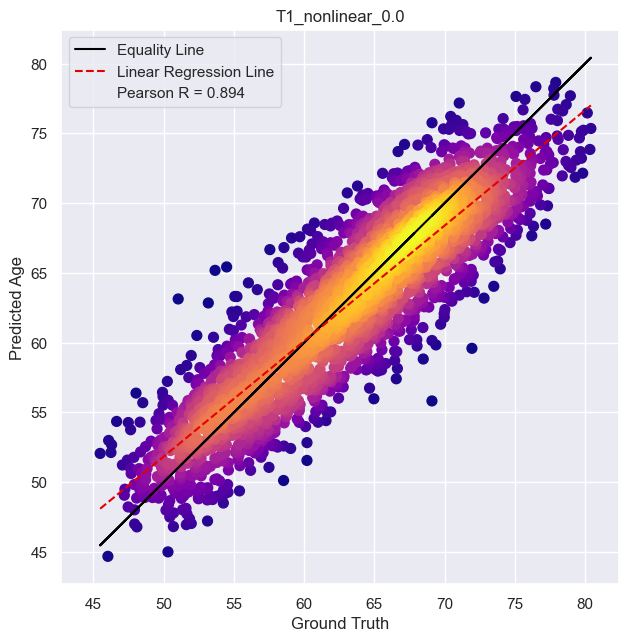

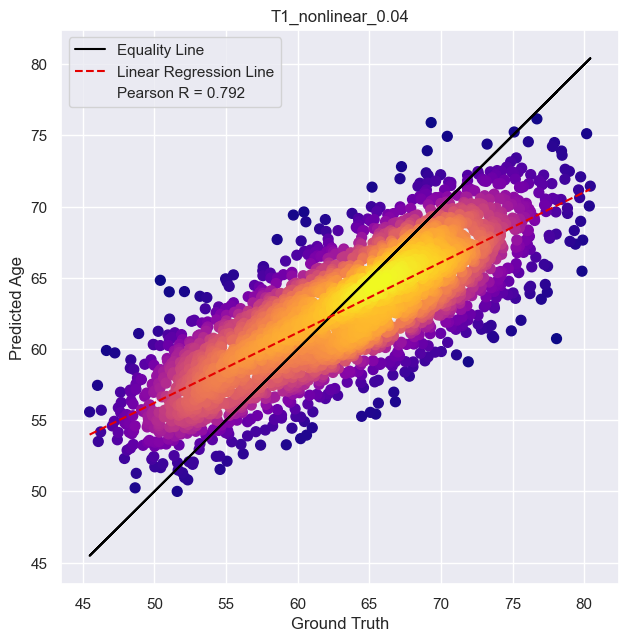

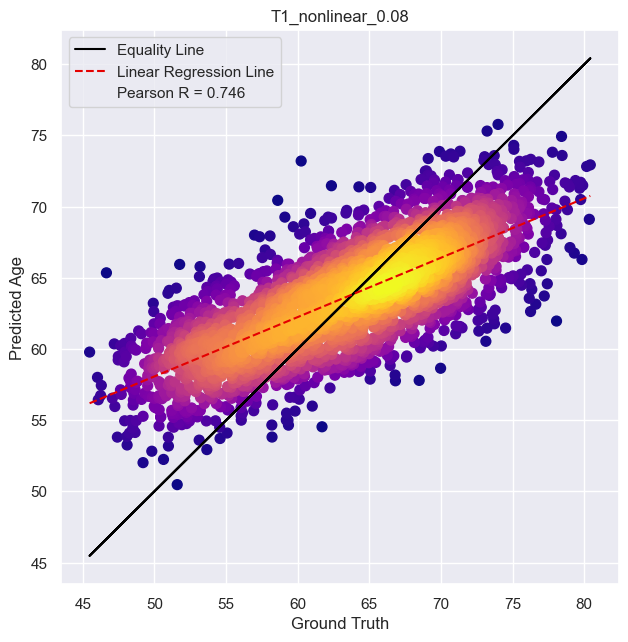

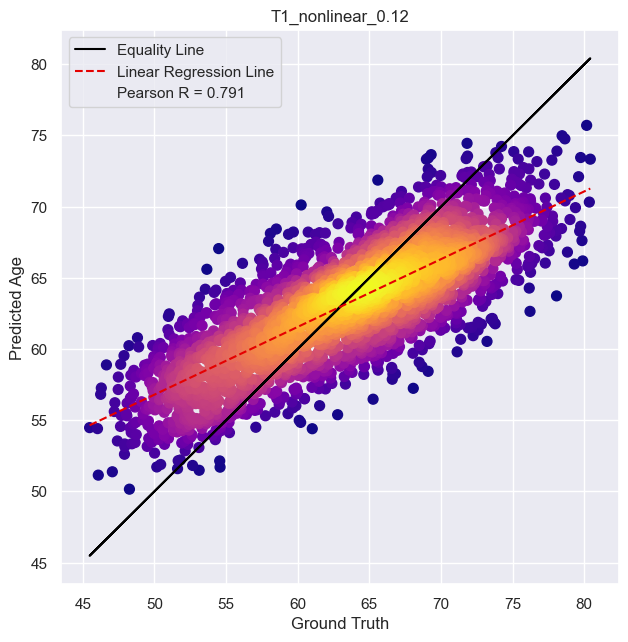

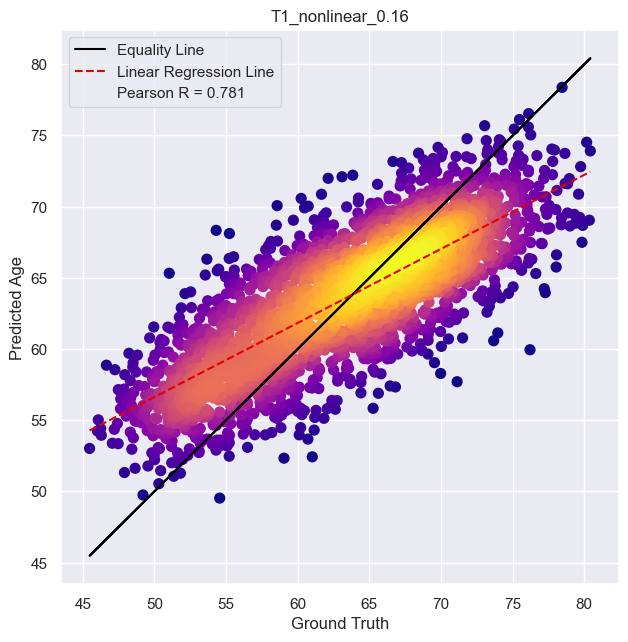

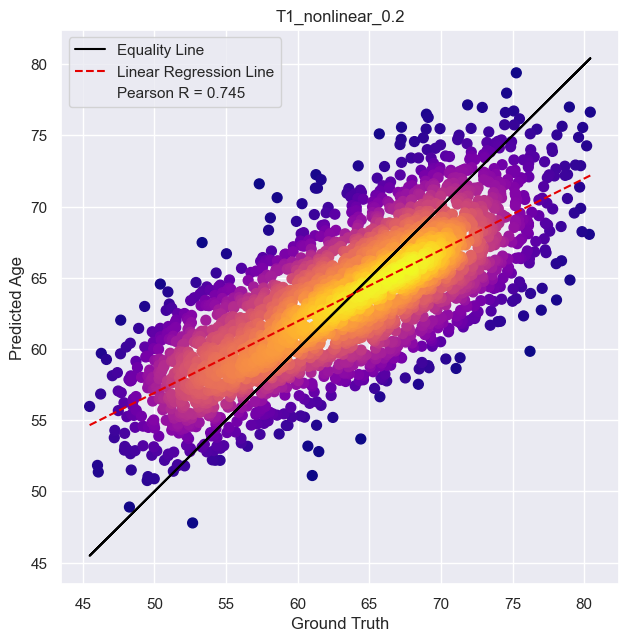

In [6]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
        y_name = 'output_age_' + str(idx2)
#         y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon' + str(idx2)
        fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod[y_name], xlabel='Ground Truth', 
                                   ylabel='Predicted Age', title=name_mod + '_' + str(noiseSTD[idx2-1]), set_scale=True)

# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     name_mod = df.iloc[idx].modality
#     fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.output_age, xlabel='Ground Truth', 
#                                ylabel='Predicted Age', title=name_mod, set_scale=True)

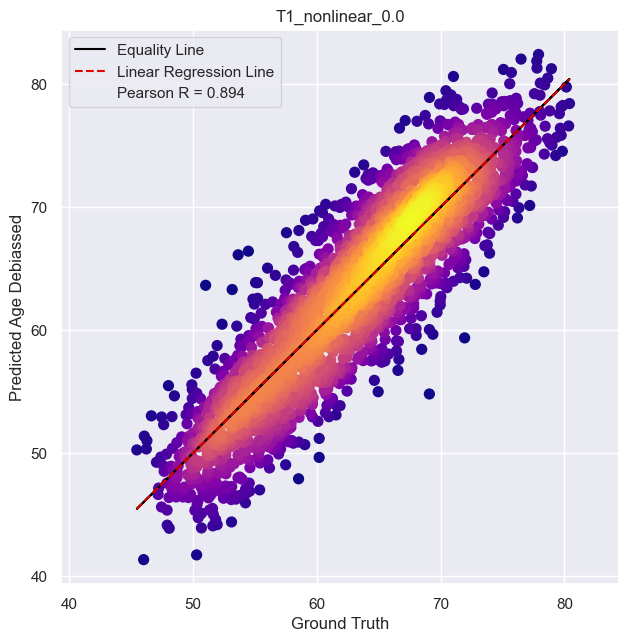

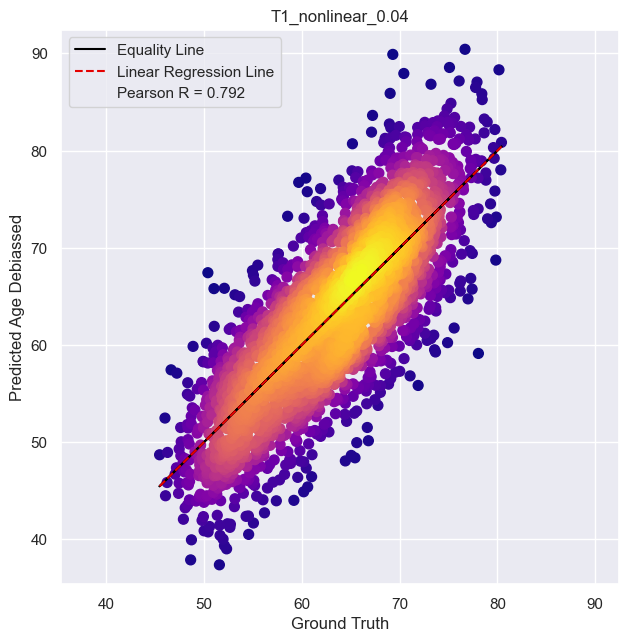

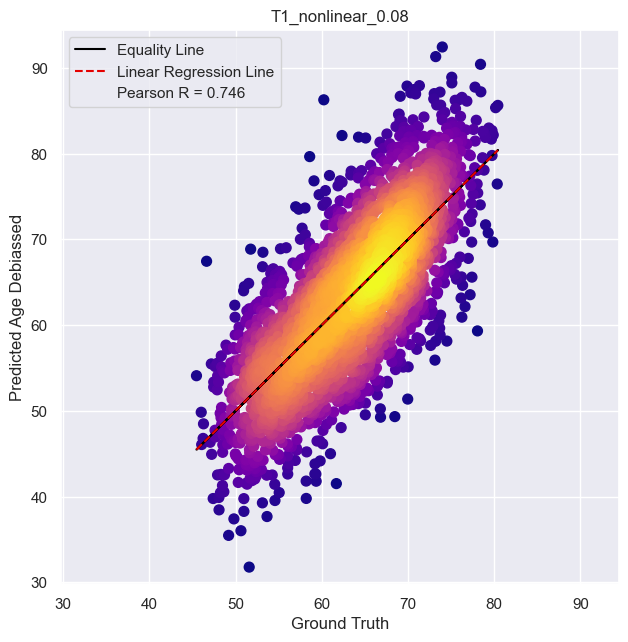

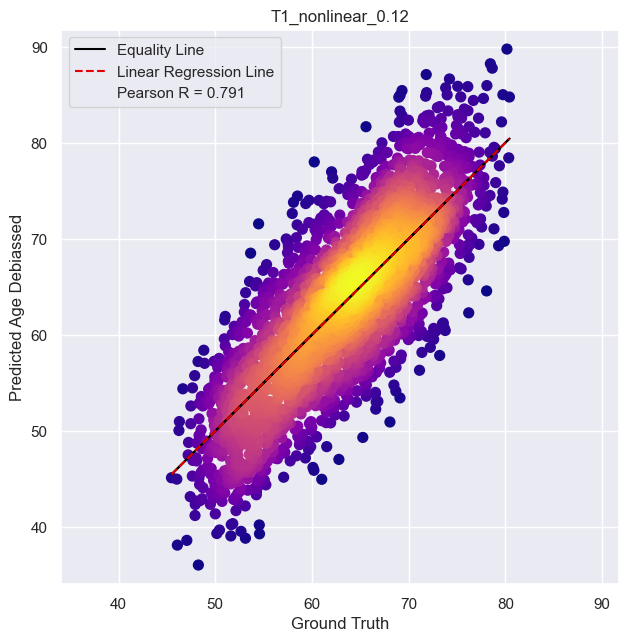

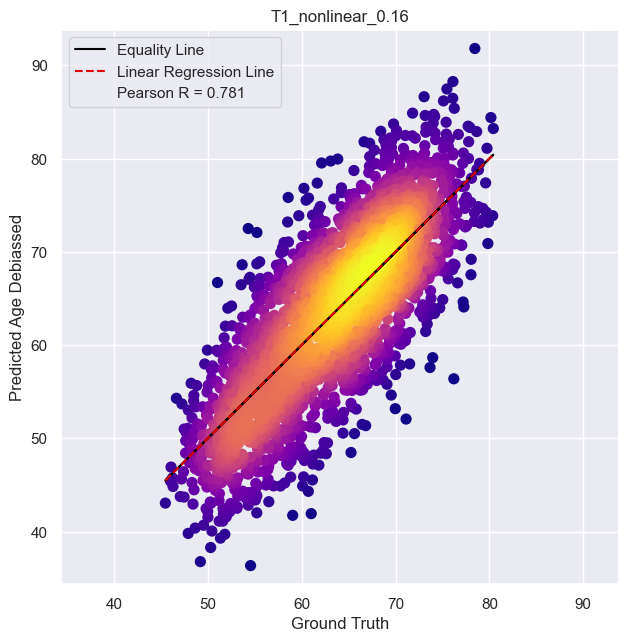

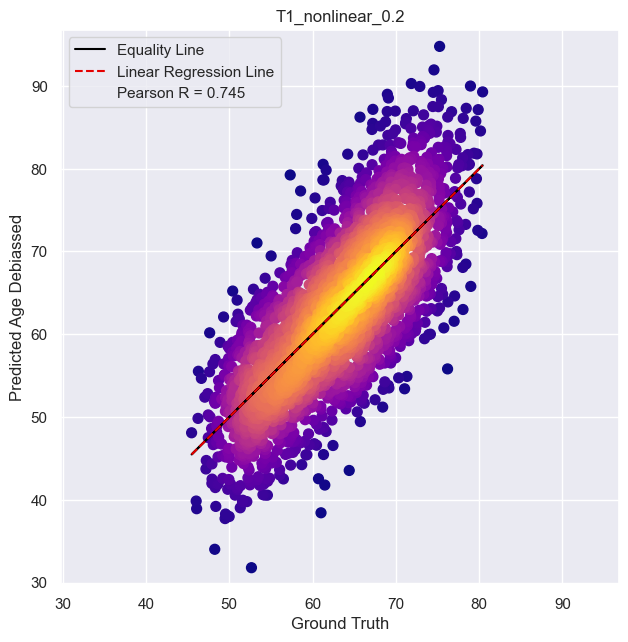

In [7]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
#         y_name = 'output_age_' + str(idx2)
        y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon' + str(idx2)
        fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod[y_name], xlabel='Ground Truth', 
                                   ylabel='Predicted Age Debiassed', title=name_mod + '_' + str(noiseSTD[idx2-1]), set_scale=True)



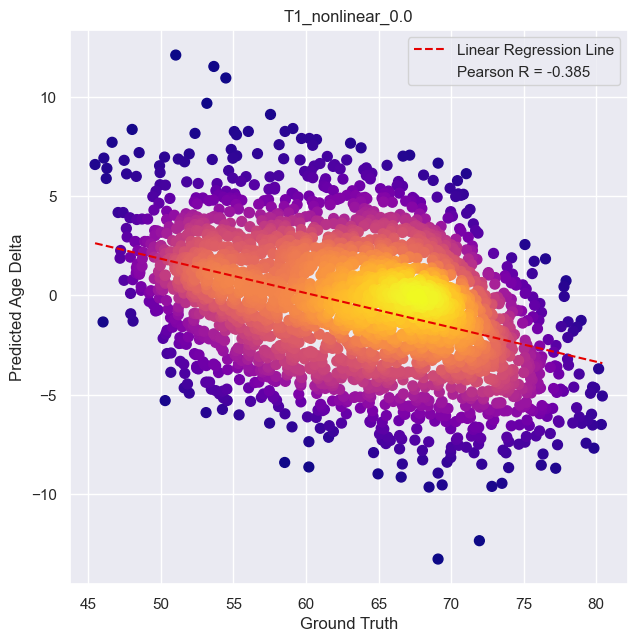

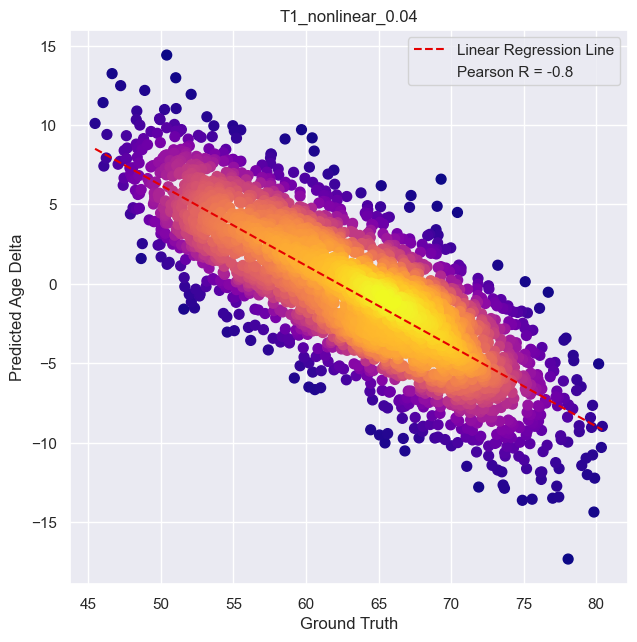

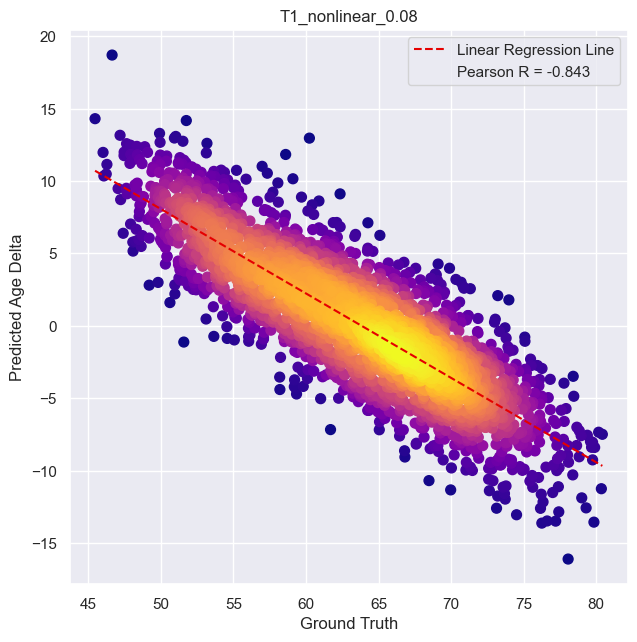

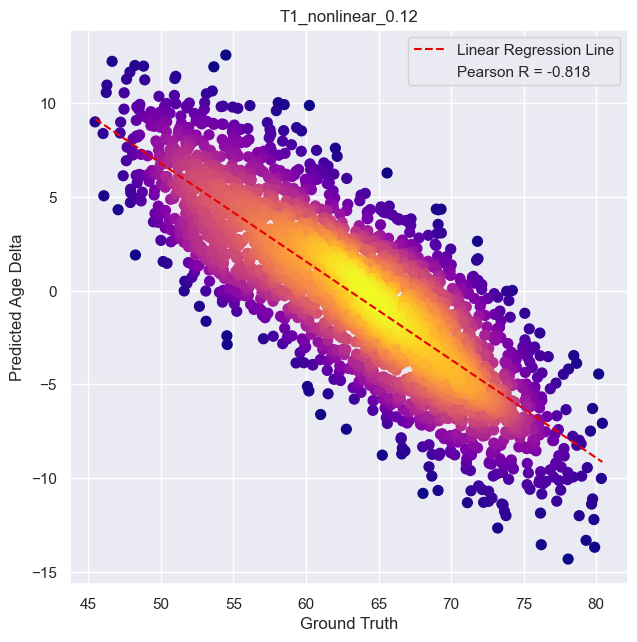

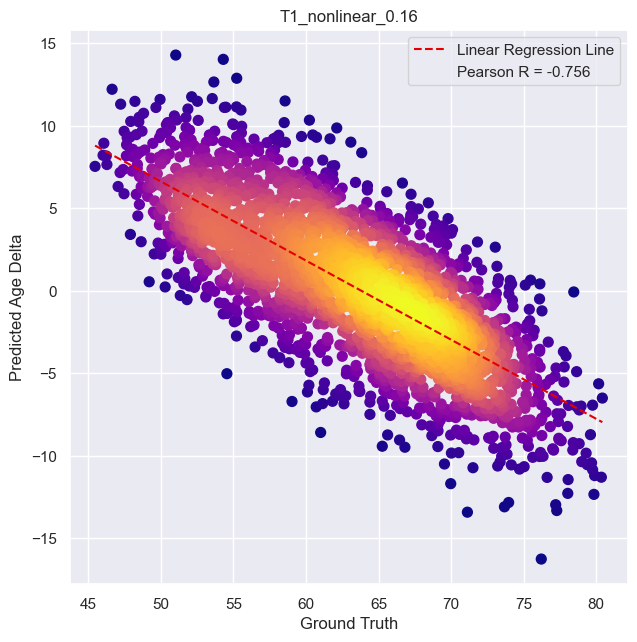

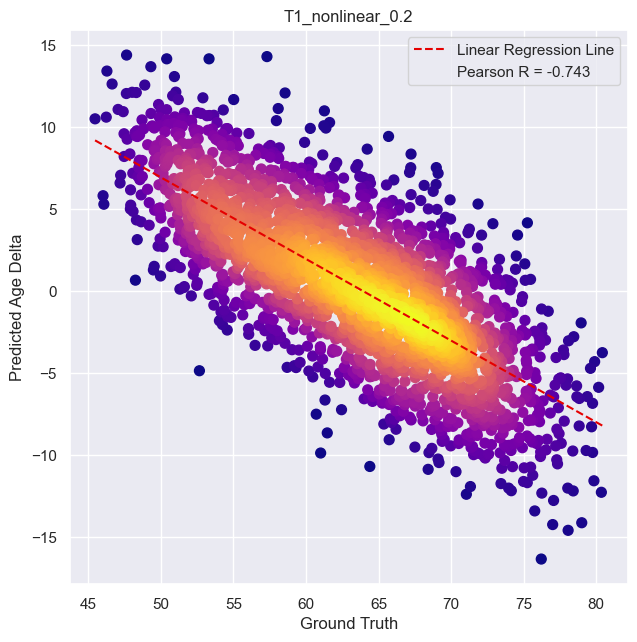

In [8]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
#         y_name = 'output_age_' + str(idx2)
#         y_name = 'output_age_decon_' + str(idx2)
        y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon' + str(idx2)
        fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod[y_name], xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta', title=name_mod + '_' + str(noiseSTD[idx2-1]), 
                                   set_scale=False, equality_line=False)



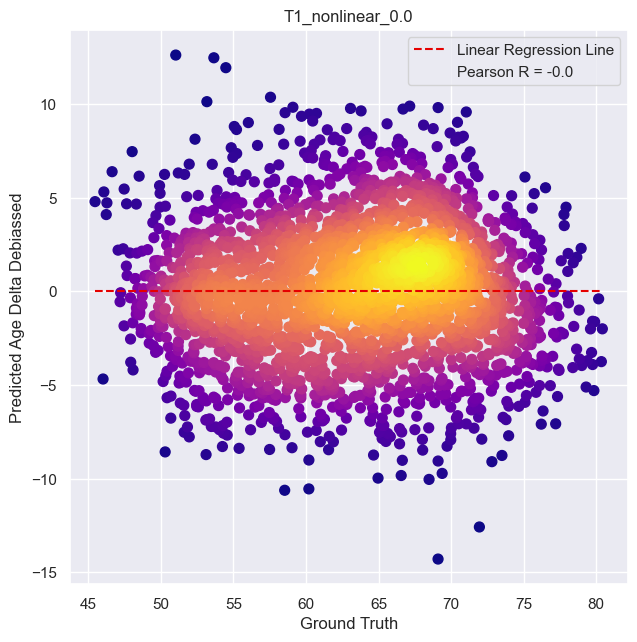

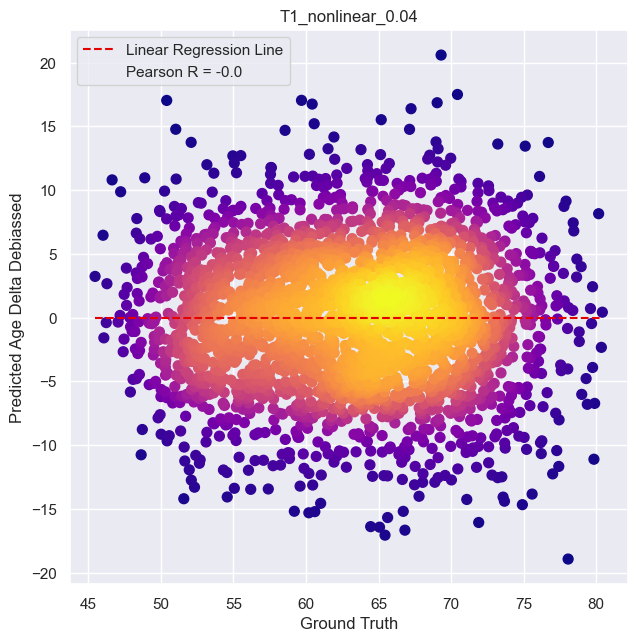

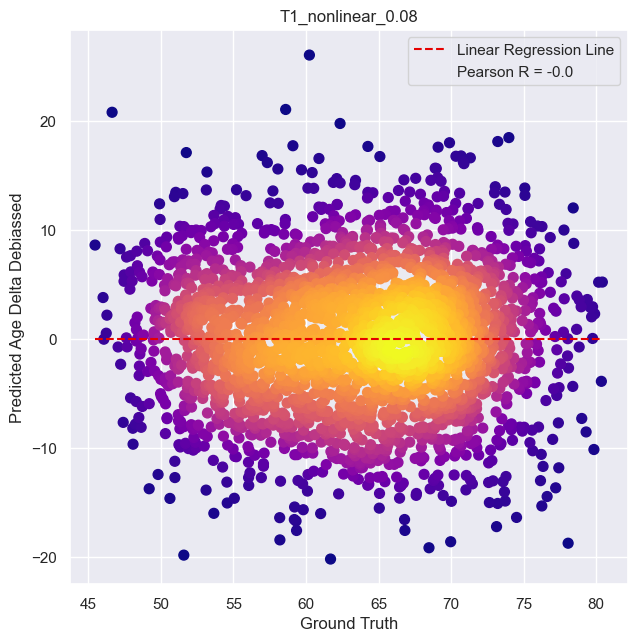

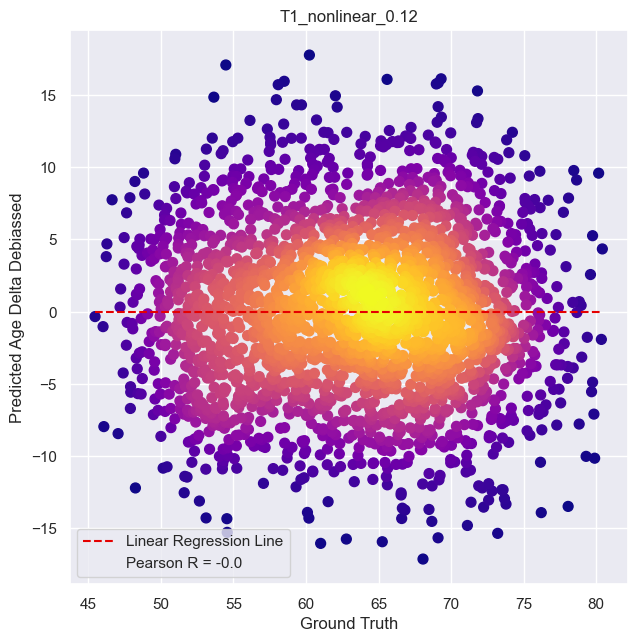

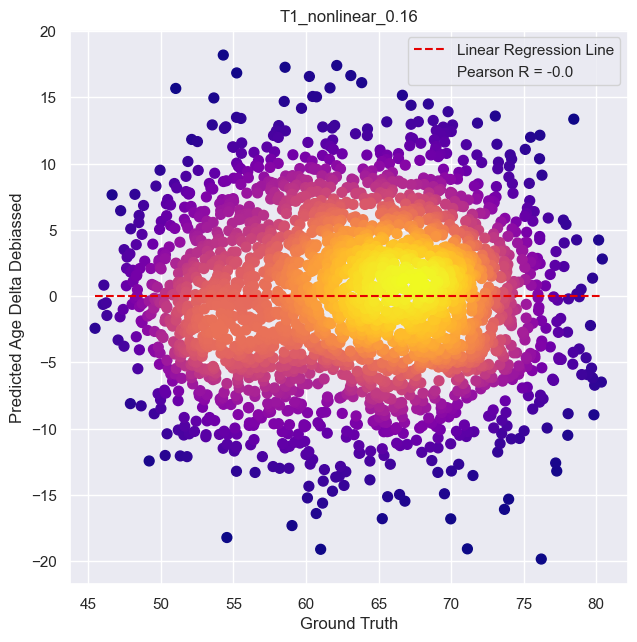

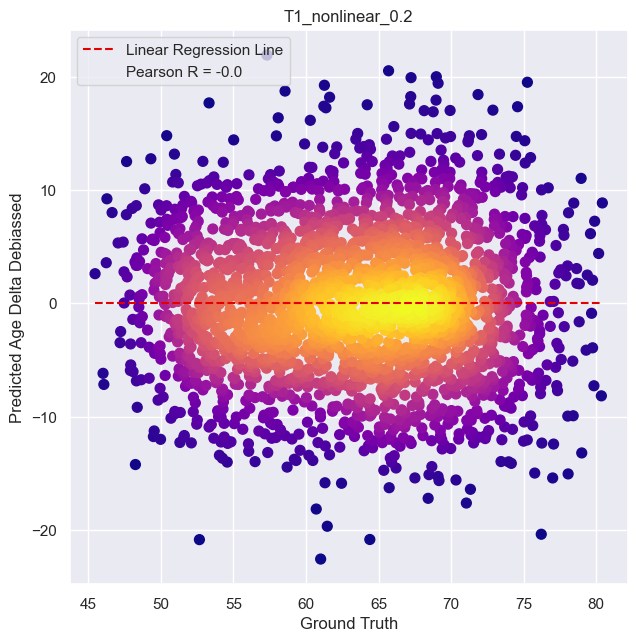

In [9]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
#         y_name = 'output_age_' + str(idx2)
#         y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
        y_name = 'age_delta_decon_' + str(idx2)
        fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod[y_name], xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta Debiassed', title=name_mod + '_' + str(noiseSTD[idx2-1]), 
                                   set_scale=False, equality_line=False)



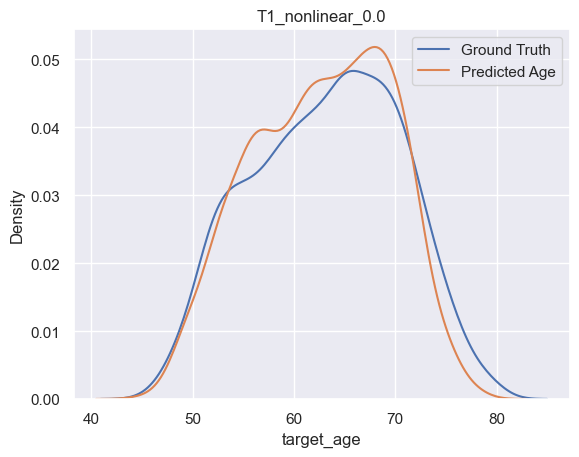

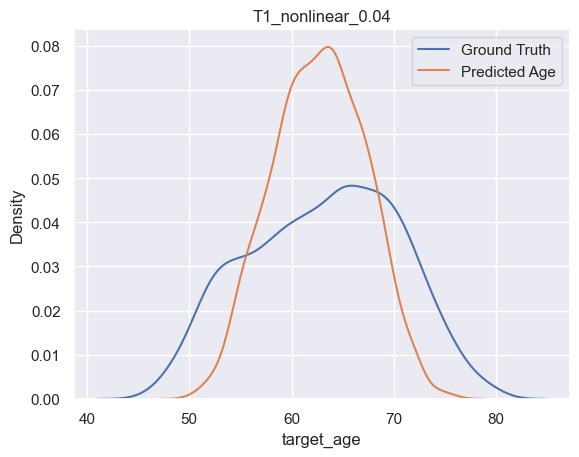

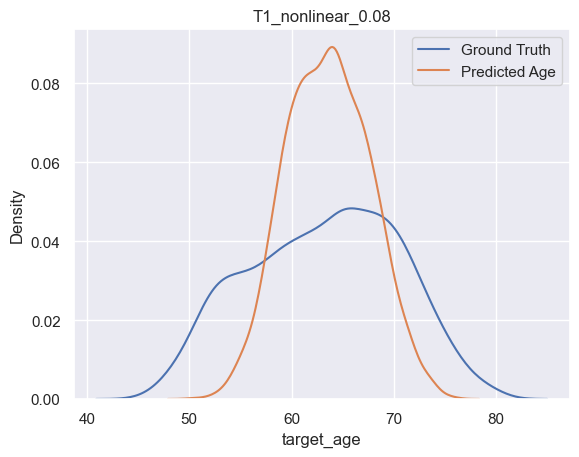

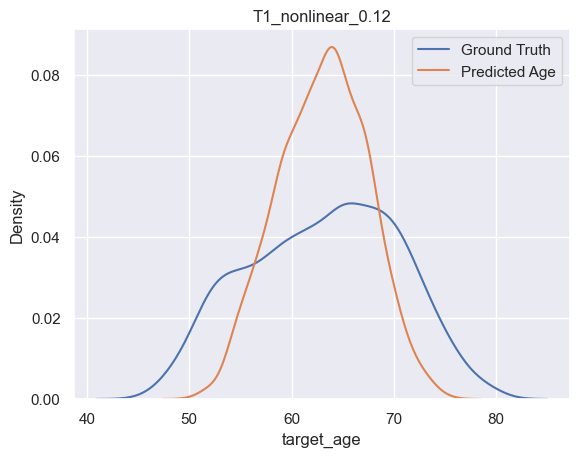

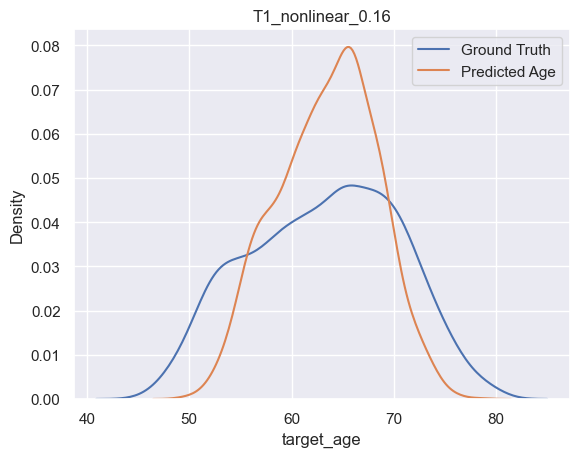

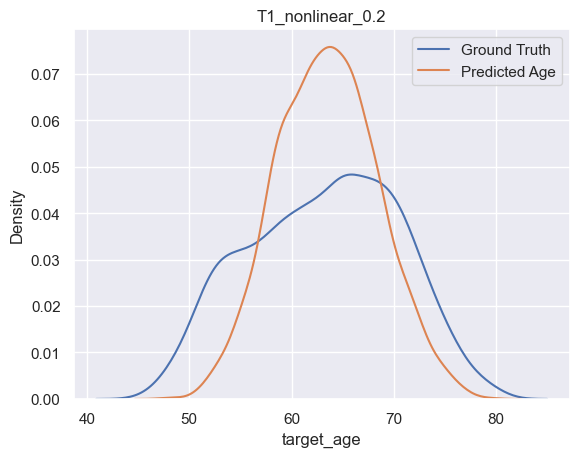

In [10]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
        y_name = 'output_age_' + str(idx2)
#         y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon_' + str(idx2)
        fig = kde_plot(x=df_mod.target_age, y=df_mod[y_name], 
                   xlabel='Ground Truth', ylabel='Predicted Age',
                   title=name_mod+ '_' + str(noiseSTD[idx2-1]))



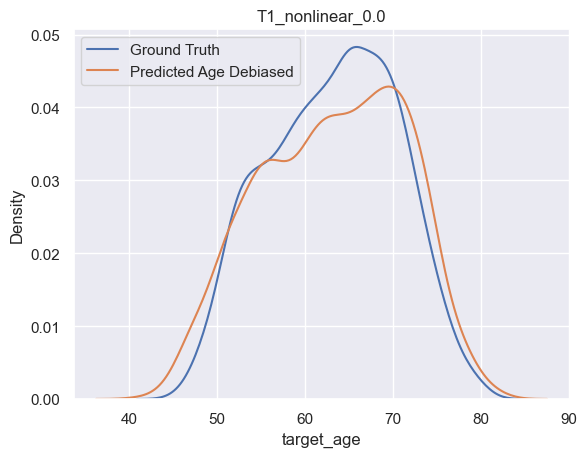

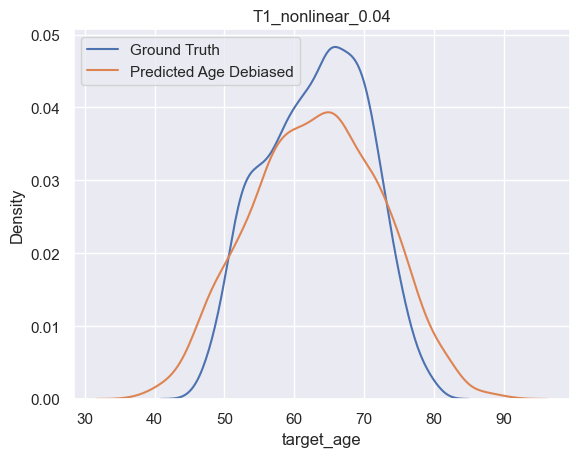

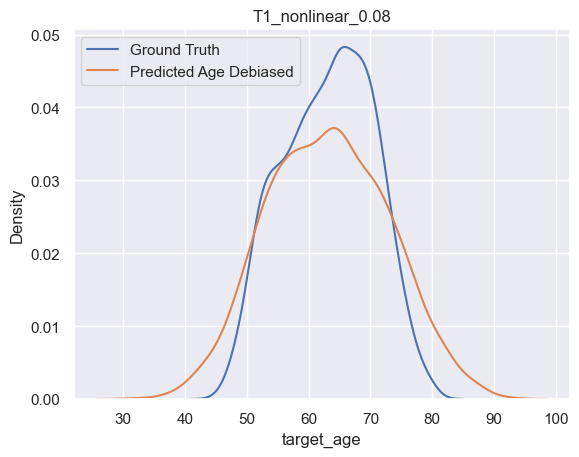

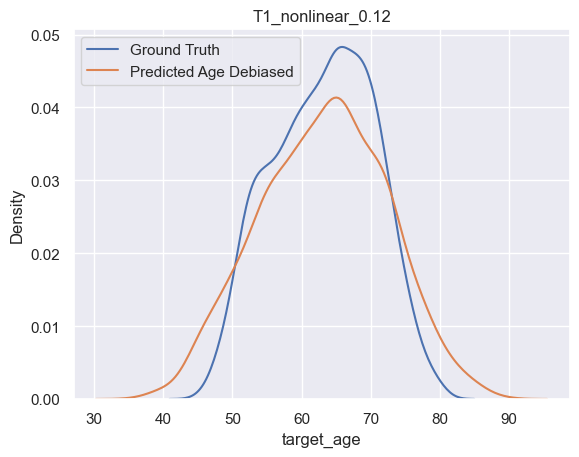

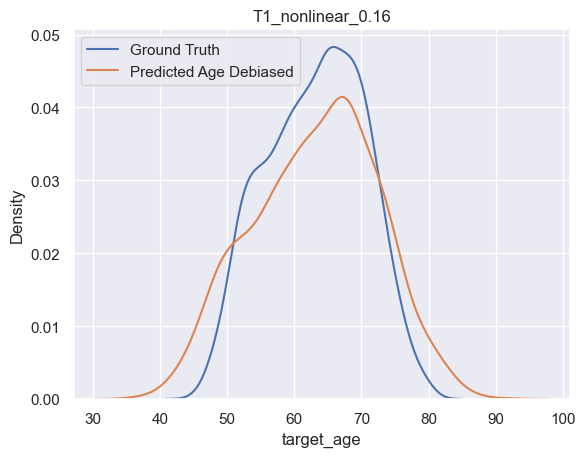

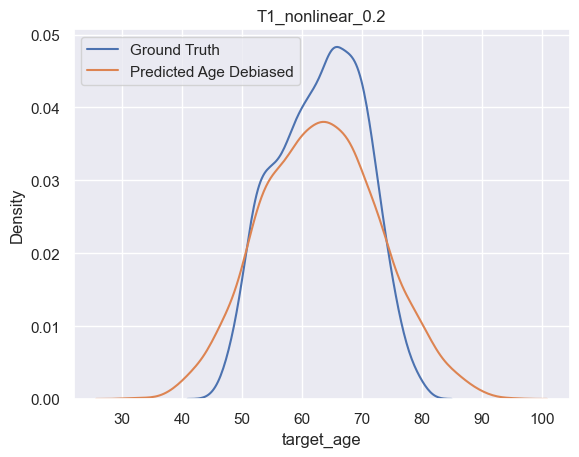

In [11]:
for idx in range(len(df1)):
    for idx2 in range(1,7):
        df_mod = df1.iloc[idx].dataframe
        name_mod = df1.iloc[idx].modality
#         y_name = 'output_age_' + str(idx2)
        y_name = 'output_age_decon_' + str(idx2)
#         y_name = 'age_delta_' + str(idx2)
#         y_name = 'age_delta_decon_' + str(idx2)
        fig = kde_plot(x=df_mod.target_age, y=df_mod[y_name], 
                   xlabel='Ground Truth', ylabel='Predicted Age Debiased',
                   title=name_mod+ '_' + str(noiseSTD[idx2-1]))
